# AGN Scratch Notebook

In [3]:
import hats
import lsdb
from hats.io.validation import is_valid_catalog

# Import Data

Select a large number of AGNs. Use SDSS AGN to start.  Find these AGNs in ZTF/PanSTARRS/Rubin ComCam data.

## Import SDSS (DR7QSO)

In [4]:
sdss_dir = "/data3/epyc/data3/hats/raw/sdss/sdss_dr7_qso_props/"
print("Valid catalog?", is_valid_catalog(sdss_dir))

Valid catalog? True


In [5]:
sdss = lsdb.read_hats(
    sdss_dir,
    columns=["RA", "DEC", "REDSHIFT", "SDSS_NAME", "LOGBH"]
)

In [6]:
sdss.head()

,RA,DEC,REDSHIFT,SDSS_NAME,LOGBH
_healpix_29,,,,,
1748843545125,45.075508,0.152306,2.2308,030018.12+000908.3,9.273159
2976627715402,44.884758,0.164801,0.8064,025932.34+000953.2,8.307456
5459300610667,45.18858,0.282409,1.7422,030045.25+001656.6,9.3182
5858887011909,45.339138,0.290646,0.4101,030121.39+001726.3,7.203714
7934686108383,45.189484,0.35918,1.4969,030045.47+002133.0,9.479626


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'SDSS DR7 QSO'}>)

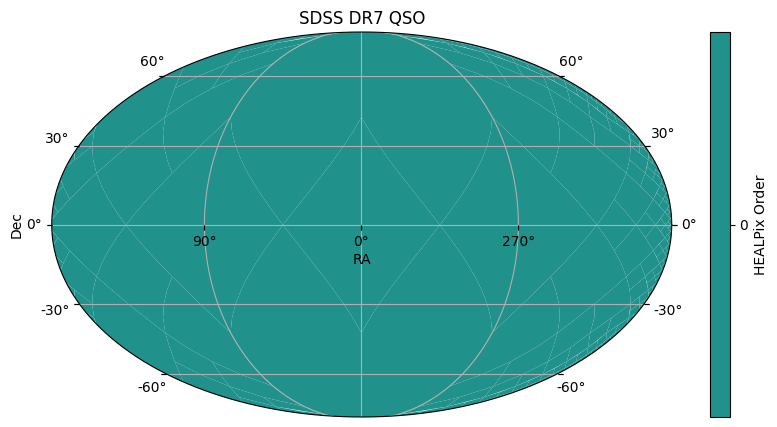

In [7]:
sdss.plot_pixels(plot_title="SDSS DR7 QSO")

## Import ZTF (w/ Margin Cache)

In [8]:
from lsdb import BoxSearch

ztf_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22/ztf_lc"
ztf_margin_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22/ztf_lc_10arcs"

ztf = lsdb.read_hats(
    ztf_path, margin_cache=ztf_margin_path, columns=[
        "objectid", "objra", "objdec", "filterid", "nepochs", "hmjd", "mag", "magerr"
    ]
)
print(f"Margin size: {ztf.margin.hc_structure.catalog_info.margin_threshold} arcsec")

Margin size: 10.0 arcsec


In [9]:
ztf

,objectid,objra,objdec,filterid,nepochs,hmjd,mag,magerr
npartitions=10839,,,,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow]
"Order: 4, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...,...


### Nesting ZTF

In [10]:
ztf_nested = ztf.nest_lists(
    base_columns=[col for col in ztf.columns if col not in ["hmjd", "mag", "magerr"]],
    name="lc",
)

In [11]:
ztf_nested

,objectid,objra,objdec,filterid,nepochs,lc
npartitions=10839,,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],"nested<hmjd: [list<element: double>], mag: [li..."
"Order: 4, Pixel: 1",...,...,...,...,...,...
...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: title={'center': 'ztf_nested'}>)

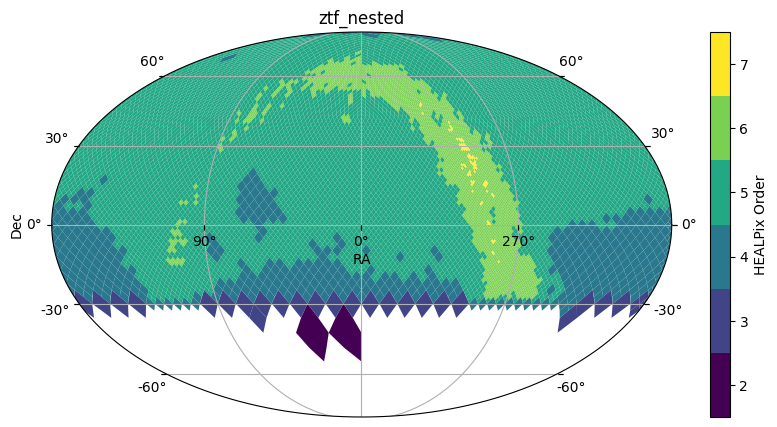

In [12]:
ztf_nested.plot_pixels(plot_title="ztf_nested")

In [ ]:
# Test: can we calculate the earliest time?

import tempfile
from dask.distributed import Client

tmp_path = tempfile.TemporaryDirectory(dir="/data3/epyc/data3/hats/raw/")
tmp_dir = tmp_path.name
with Client(n_workers=8, threads_per_worker=1, local_directory=tmp_dir) as client:
    min_mjd = (
        ztf_nested.reduce(
            lambda mjd: {"min_mjd": mjd.min()},
            "lc.hmjd",
            meta={"min_mjd": float},
        )["min_mjd"]
        .min()
        .compute()
    )
min_mjd

# Last attempt: Feb 17 over lunch, ran for 76 minutes before I gave up on this. Ate up at least 300 GB memory during run...

/astro/users/olynn/.conda/envs/p311/lib/python3.11/tempfile.py:934: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/data3/epyc/data3/hats/raw/tmpao31qgc4'>
  _warnings.warn(warn_message, ResourceWarning)
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/node.py:173: ResourceWarning: unclosed <socket.socket fd=69, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35288 instead
  warnings.warn(
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 16.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.d

TimeoutError: 

# Crossmatching SDSS x ZTF

## Option 1: Can we crossmatch using a nested catalog?

As it turns out, not really. Seems related to: https://github.com/astronomy-commons/lsdb/issues/551

In [13]:
ztf_nested

,objectid,objra,objdec,filterid,nepochs,lc
npartitions=10839,,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],"nested<hmjd: [list<element: double>], mag: [li..."
"Order: 4, Pixel: 1",...,...,...,...,...,...
...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...


In [14]:
sdss

,RA,DEC,REDSHIFT,SDSS_NAME,LOGBH
npartitions=12,,,,,
"Order: 0, Pixel: 0",double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow]
"Order: 0, Pixel: 1",...,...,...,...,...
...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...


In [15]:
sdss_x_ztf_nested = sdss.crossmatch(ztf_nested, n_neighbors=1, radius_arcsec=3, suffixes=["_sdss", "_ztf"])

In [16]:
sdss_x_ztf_nested

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,objectid_ztf,objra_ztf,objdec_ztf,filterid_ztf,nepochs_ztf,lc_ztf,_dist_arcsec
npartitions=2760,,,,,,,,,,,,
"Order: 4, Pixel: 0",double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],"nested<hmjd: [list<element: double>], mag: [li...",double[pyarrow]
"Order: 4, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12282",...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...,...,...,...,...,...


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'SDSS x ZTF Nested'}>)

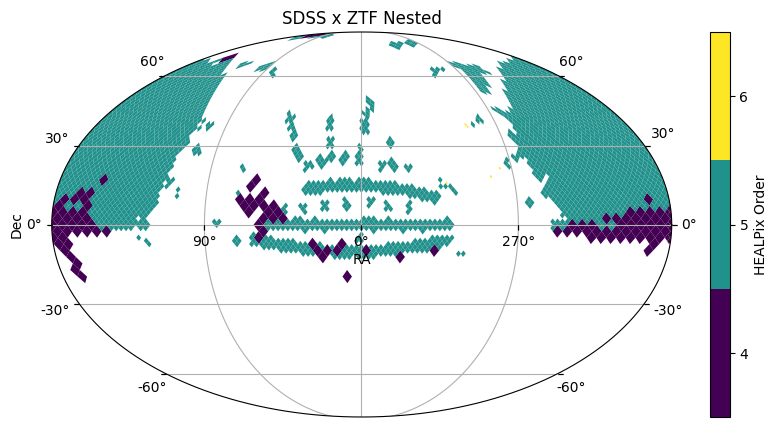

In [ ]:
sdss_x_ztf_nested.plot_pixels(plot_title="SDSS x ZTF Nested")

In [ ]:
# Test: can we calculate the earliest time?

import tempfile
from dask.distributed import Client

tmp_path = tempfile.TemporaryDirectory(dir="/data3/epyc/data3/hats/raw/")
tmp_dir = tmp_path.name
with Client(n_workers=8, threads_per_worker=1, local_directory=tmp_dir) as client:
    min_mjd = (
        sdss_x_ztf_nested.reduce(
            lambda mjd: {"min_mjd_ztf": mjd.min()},
            "lc_ztf.hmjd",
            meta={"min_mjd_ztf": float},
        )["min_mjd_ztf"]
        .min()
        .compute()
    )
min_mjd

/astro/users/olynn/.conda/envs/p311/lib/python3.11/tempfile.py:934: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/data3/epyc/data3/hats/raw/tmprd7z6jnv'>
  _warnings.warn(warn_message, ResourceWarning)
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/node.py:173: ResourceWarning: unclosed <socket.socket fd=69, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41106 instead
  warnings.warn(
/astro/users/olynn/.conda/envs/p311/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 10.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.d

ValueError: Metadata mismatch found in `from_delayed`.

Partition type: `nested_pandas.nestedframe.core.NestedFrame`
+----------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------+
| Column   | Found                                                 | Expected                                                                                           |
+----------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------+
| 'lc_ztf' | nested<hmjd: [double], mag: [float], magerr: [float]> | nested<hmjd: [list<element: double>], mag: [list<element: float>], magerr: [list<element: float>]> |
+----------+-------------------------------------------------------+----------------------------------------------------------------------------------------------------+

## Option 2: Can we nest a crossmatched catalog?

In [21]:
ztf

,objectid,objra,objdec,filterid,nepochs,hmjd,mag,magerr
npartitions=10839,,,,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow]
"Order: 4, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...,...


In [22]:
sdss

,RA,DEC,REDSHIFT,SDSS_NAME,LOGBH
npartitions=12,,,,,
"Order: 0, Pixel: 0",double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow]
"Order: 0, Pixel: 1",...,...,...,...,...
...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...


In [23]:
sdss_x_ztf = sdss.crossmatch(ztf, n_neighbors=1, radius_arcsec=3, suffixes=["_sdss", "_ztf"])

(<Figure size 1000x500 with 2 Axes>, <WCSAxes: title={'center': 'SDSS x ZTF'}>)

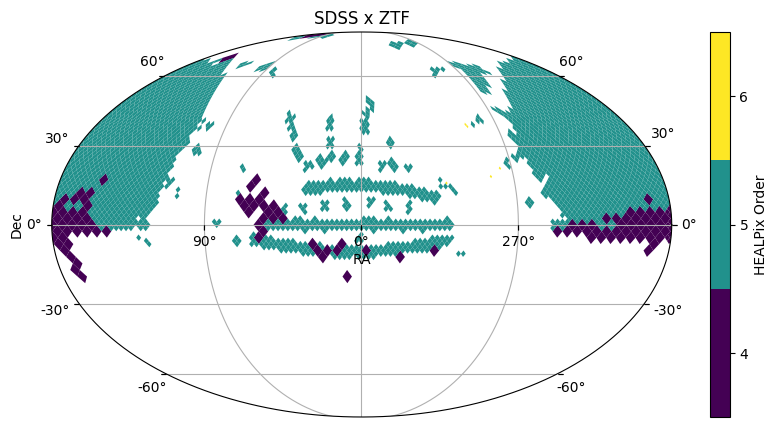

In [24]:
sdss_x_ztf.plot_pixels(plot_title="SDSS x ZTF")

In [25]:
sdss_x_ztf

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,objectid_ztf,objra_ztf,objdec_ztf,filterid_ztf,nepochs_ztf,hmjd_ztf,mag_ztf,magerr_ztf,_dist_arcsec
npartitions=2760,,,,,,,,,,,,,,
"Order: 4, Pixel: 0",double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow],double[pyarrow]
"Order: 4, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12282",...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [26]:
import dask

dask.config.set({"dataframe.convert-string": False})

In [34]:
dask.config.get("dataframe")

{'backend': 'pandas',
 'shuffle': {'method': None, 'compression': None},
 'parquet': {'metadata-task-size-local': 512,
  'metadata-task-size-remote': 1,
  'minimum-partition-size': 75000000},
 'convert-string': False,
 'query-planning': None}

In [28]:
# nf= nf.astype({“colname”: pd.ArrowDtype(pa.list_(pa.int64()))})

import pandas as pd
import pyarrow as pa

#sdss_x_ztf = sdss_x_ztf.astype({"RS_sdss": pd.ArrowDtype(pa.float64())})

In [35]:
sdss_x_ztf_nested = sdss_x_ztf.nest_lists(
    base_columns=[col for col in ztf.columns if col not in ["hmjd_ztf", "mag_ztf", "magerr_ztf"]],
    name="lc_ztf",
)

TypeError: List column 'RA_sdss' dtype (double[pyarrow]) is not a pyarrow list dtype.
Refer to the docstring for guidance on dtype requirements and assignment.